In [1]:
# from IPython.display import GeoJSON

# GeoJSON({
#     "type": "Feature",
#     "geometry": {
#         "type": "Point",
#         "coordinates": [-118.4563712, 34.0163116]
#     }
# })

In [2]:
import sys
from data import api_key 
key=api_key.google_api_key

In [3]:
# load data
from glob import glob 
raw_data = glob("data/*.txt")
raw_data[0]

'data/KRI-DAC_Jeju_data6.txt'

In [4]:
# conncat data
from glob import glob 
concat_list=[]
for i in range(0,len(raw_data)):
    df=pd.read_csv(raw_data[i])
    df["month"]=raw_data[i].split(".")[0][-1:]
    concat_list.append(df)

In [5]:
df=pd.concat(concat_list)

In [6]:
#dropped useless columns 
df.columns=df.columns.str.lower()
df.drop(['sido','x',"objectid",'y'],axis = 1, inplace=True)

In [7]:
#rename koren named columns to eng
df

,field1,ym,sigungu,franclass,type,time,totalspent,disspent,numofspent,numofdisspent,point_x,point_y,month
0,1,202006,제주시,영세,일반한식,00시,502000,0,10,0,877005.9834,1.479766e+06,6
1,2,202006,제주시,영세,단란주점,00시,1520000,0,8,0,877005.7447,1.479816e+06,6
2,3,202006,제주시,중소1,편의점,00시,482310,0,35,0,877056.6756,1.479616e+06,6
3,4,202006,제주시,영세,편의점,00시,38050,5450,3,1,877055.9593,1.479766e+06,6
4,5,202006,제주시,영세,일반한식,00시,32000,32000,1,1,877055.4817,1.479866e+06,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
280080,280081,202008,제주시,영세,편의점,x시,13700,0,2,0,950266.5976,1.502458e+06,8
280081,280082,202008,제주시,영세,일반한식,x시,56000,0,1,0,950317.5379,1.502258e+06,8
280082,280083,202008,제주시,영세,일반한식,x시,28000,0,1,0,950469.1585,1.501909e+06,8
280083,280084,202008,제주시,중소1,중국음식,x시,46000,0,3,0,950574.6388,1.500760e+06,8


In [8]:
from pyproj import Proj, transform 
proj_itrf = Proj(init='epsg:5178')
proj_wgs84 = Proj(init='epsg:4326')
df["lon"],df["lat"] = transform(proj_itrf,proj_wgs84,df['point_x'],df["point_y"])
df.drop(['point_x','point_y',"field1",'ym'],inplace=True, axis=1)

In [9]:
# df['lon_lat']=df['lon'].astype(str)+'_'+df['lat'].astype(str)

In [10]:
# df_lon_lat=df['lon_lat'].drop_duplicates()
# df_lon_lat

In [11]:
# import googlemaps
# from datetime import datetime

# gmaps = googlemaps.Client(key) 
# reverse_geocode_result = gmaps.reverse_geocode((33.302315,126.176746))
# reverse_geocode_result
# # geocode_result  

In [12]:
# import json
# m=folium.Map(location=[48,-102],zoom_start=3)
# folium.Choropleth(
#     geo_data='./data/03_us-states.json',
#     data=state_data, columns=["State",'Unemployment'],
#     nan_fill_color="purple", nan_fill_opacity=0.4,
#     key_on="    ", fill_color="YlGn",
#     legend_name="Unemployment Rate (%)"
# ).add_to(m)
# m

In [13]:
#import rename module  
import type_names
input_data=type_names.rename()
for key, value in input_data:
    df["type"].replace(dict.fromkeys(key, value), inplace=True)

In [14]:
df.head()

,sigungu,franclass,type,time,totalspent,disspent,numofspent,numofdisspent,month,lon,lat
0,제주시,영세,dinning,00시,502000,0,10,0,6,126.176746,33.305090
1,제주시,영세,liquor,00시,1520000,0,8,0,6,126.176737,33.305540
2,제주시,중소1,grocery,00시,482310,0,35,0,6,126.177311,33.303746
3,제주시,영세,grocery,00시,38050,5450,3,1,6,126.177283,33.305098
4,제주시,영세,dinning,00시,32000,32000,1,1,6,126.177264,33.305999


In [15]:
# data preprocessing

df['sigungu']=df['sigungu'].replace(['제주시','서귀포시'],['jeju','Seogwipo'])
df=df[df['time']!='x시'].reset_index(drop=True) # payments canceled 
df['time']=df['time'].apply(lambda x : x[:2])
df.franclass=df.franclass.replace(['영세', '중소1', '중소', '중소2', '일반'],['under_0.3m','under_1m','under_0.5m','under_3m','over_3m'])
df_final=df.rename(columns={'sigungu':'city','franclass':'class','totalspent':'total_income','disspent':'subsidies_income','numofspent':'num_of_payments','numofdisspent':'num_of_subspayment'})
df_final[['total_income','subsidies_income']]=df_final[['total_income','subsidies_income']].astype(int).apply(lambda x:x/1000) #won to $, 1000:1
df_final['non_subsidies_income']=df_final['total_income']-df_final['subsidies_income']

In [16]:
df_final

,city,class,type,time,total_income,subsidies_income,num_of_payments,num_of_subspayment,month,lon,lat,non_subsidies_income
0,jeju,under_0.3m,dinning,00,502.00,0.00,10,0,6,126.176746,33.305090,502.00
1,jeju,under_0.3m,liquor,00,1520.00,0.00,8,0,6,126.176737,33.305540,1520.00
2,jeju,under_1m,grocery,00,482.31,0.00,35,0,6,126.177311,33.303746,482.31
3,jeju,under_0.3m,grocery,00,38.05,5.45,3,1,6,126.177283,33.305098,32.60
4,jeju,under_0.3m,dinning,00,32.00,32.00,1,1,6,126.177264,33.305999,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...
1072434,jeju,under_0.3m,dinning,23,65.00,0.00,4,0,8,126.954829,33.516019,65.00
1072435,jeju,under_0.3m,grocery,23,738.45,0.00,36,0,8,126.954829,33.516019,738.45
1072436,jeju,under_0.5m,grocery,23,331.63,0.00,26,0,8,126.954818,33.516921,331.63
1072437,jeju,under_0.3m,grocery,23,374.10,0.00,12,0,8,126.955373,33.515573,374.10


In [19]:
# visualization
import math
df_city_group= df_final.groupby('city')['total_income','non_subsidies_income',"subsidies_income"].sum() 
df_city_group

,total_income,non_subsidies_income,subsidies_income
city,,,
Seogwipo,1.793751e+08,1.702841e+08,9.090953e+06
jeju,4.979605e+08,4.713177e+08,2.664270e+07


Text(0.5, 1.0, 'subsidies_income by city')

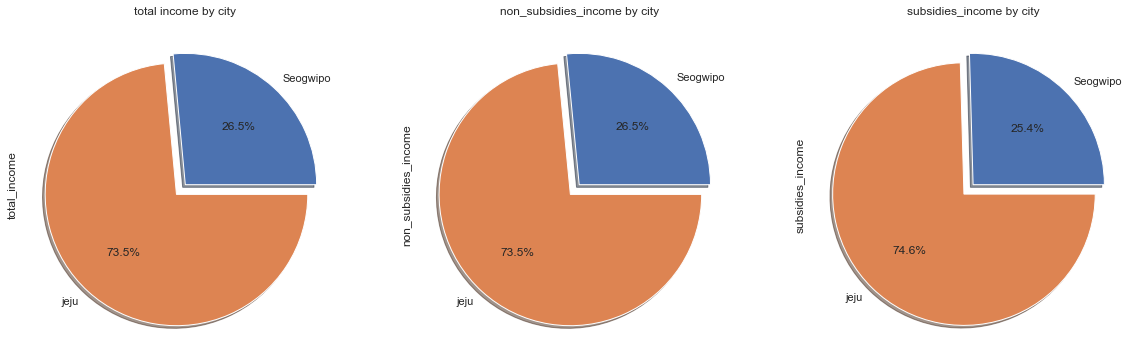

In [33]:
f, ax = plt.subplots(1,3, figsize=(20,10))
df_city_group['total_income'].plot.pie(explode=[0,0.1], autopct='%1.1f%%',ax=ax[0], shadow=True)
ax[0].set_title('total income by city')

df_city_group['non_subsidies_income'].plot.pie(explode=[0,0.1], autopct='%1.1f%%',ax=ax[1], shadow=True)
ax[1].set_title('non_subsidies_income by city')

df_city_group['subsidies_income'].plot.pie(explode=[0,0.1], autopct='%1.1f%%',ax=ax[2], shadow=True)
ax[2].set_title('subsidies_income by city')
